In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import theano
print("Theano version:",theano.__version__)
import sys
print (sys.version)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Couldn't import dot_parser, loading of dot files will not be possible.
Theano version: 0.9.0
2.7.12 |Anaconda 2.1.0 (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


## Grab the input data

In [3]:
!./grab_data.sh

File task0importancescores.npy exists already
File task0hypimpscores.npy exists already
File sequences.txt exists already


### Functions for one-hot encoding sequences

In [3]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip("\n") for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split("\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta)

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [12]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences]

Double check by plotting

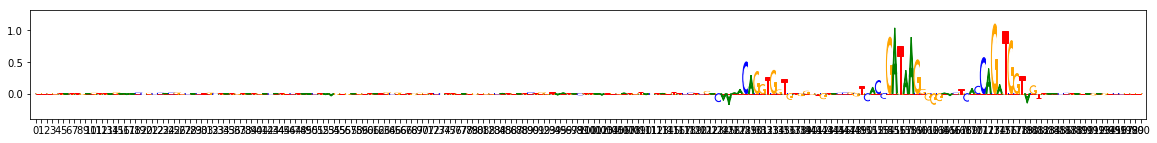

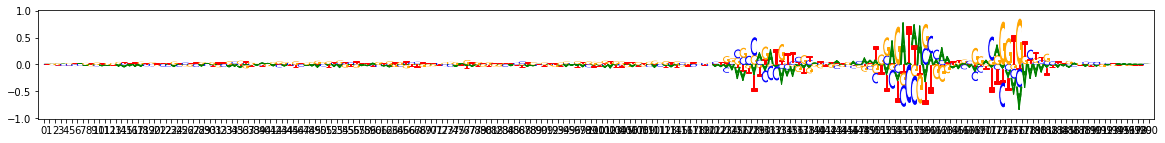

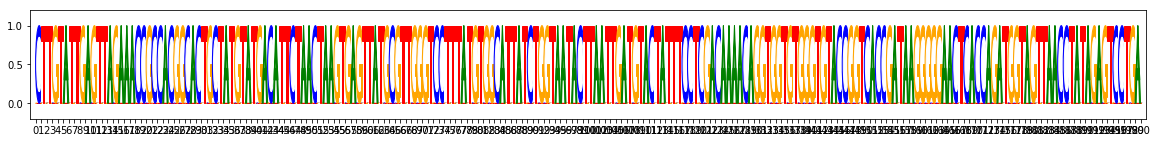

In [10]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0])
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0])
viz_sequence.plot_weights(onehot_data[0])

## Run TF-MoDISco

TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there is just one task, there are only 2 possible metaclusters: +1 for the task and -1 for the task. The -1 metacluster does not turn up any motifs after noise filtering, but the +1 metacluster produces two motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 50 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.

On task task0
Computing windowed sums
Computing threshold


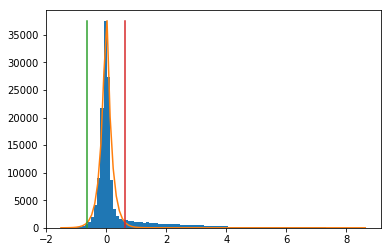

Computed threshold 0.6416454084537142
Got 1715 coords
On task task1
Computing windowed sums
Computing threshold


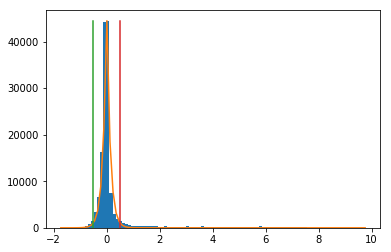

Computed threshold 0.5160286106142382
Got 1407 coords
On task task2
Computing windowed sums
Computing threshold


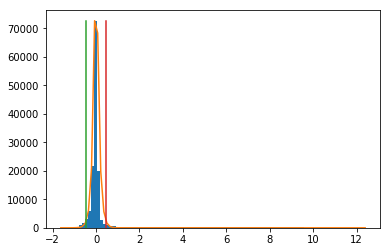

Computed threshold 0.4456595157624062
Got 1528 coords
After resolving overlaps, got 2462 seqlets
5 activity patterns with support >= 200 out of 27 possible patterns
Metacluster sizes:  [778, 606, 381, 357, 283]
Idx to activities:  {0: '1,0,1', 1: '1,1,0', 2: '0,1,0', 3: '0,0,1', 4: '1,1,1'}
On metacluster 4
Metacluster size 283
Relevant tasks:  ('task0', 'task1', 'task2')
Relevant signs:  (1, 1, 1)
(Round 1) num seqlets: 283
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.37 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.0 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affmat calculation job
Job completed 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.9s finished


Louvain completed 200 runs in 1.41447591782 seconds
Wrote graph to binary file in 0.0526621341705 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.555657
Louvain completed 51 runs in 0.744956970215 seconds
Preproc + Louvain took 2.28584384918 s
Got 7 clusters after round 1
Counts:
{0: 106, 1: 53, 2: 43, 3: 33, 4: 22, 5: 15, 6: 3}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 106 seqlets
Trimmed 10 out of 106
Skipped 5 seqlets
Dropping cluster 0 with 91 seqlets due to sign disagreement
Aggregating for cluster 1 with 53 seqlets
Trimmed 5 out of 53
Skipped 1 seqlets
Aggregating for cluster 2 with 43 seqlets
Trimmed 3 out of 43
Skipped 1 seqlets
Aggregating for cluster 3 with 33 seqlets
Trimmed 1 out of 33
Skipped 1 seqlets
Dropping cluster 3 with 31 seqlets due to sign disagreement
Aggregating for cluster 4 with 22 seqlets
Trimmed 4 out of 22
Aggregating for cluster 5 with 15 seqlets
Trimmed 0 out of 15
Skipped 3 seql

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.8s finished


Louvain completed 200 runs in 1.27891921997 seconds
Wrote graph to binary file in 0.0204889774323 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.580819
Louvain completed 51 runs in 0.659311056137 seconds
Preproc + Louvain took 2.00105404854 s
Got 5 clusters after round 2
Counts:
{0: 42, 1: 40, 2: 14, 3: 11, 4: 8}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 42 seqlets
Trimmed 0 out of 42
Aggregating for cluster 1 with 40 seqlets
Trimmed 1 out of 40
Aggregating for cluster 2 with 14 seqlets
Trimmed 1 out of 14
Aggregating for cluster 3 with 11 seqlets
Trimmed 0 out of 11
Aggregating for cluster 4 with 8 seqlets
Trimmed 0 out of 8
Got 5 clusters
Splitting into subclusters...
Merging on 5 clusters
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 0 & 2 with prob 6.422159693630823e-05 and sim 2.79666133351596
Collapsing 0 & 3 with prob 1.8615541991453276e-

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.0s finished


Louvain completed 200 runs in 1.51298713684 seconds
Wrote graph to binary file in 0.0395829677582 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.749237
Louvain completed 51 runs in 0.715884208679 seconds
Preproc + Louvain took 2.33169007301 s
Got 5 clusters after round 1
Counts:
{0: 82, 1: 69, 2: 65, 3: 49, 4: 39}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 82 seqlets
Trimmed 5 out of 82
Skipped 9 seqlets
Dropping cluster 0 with 68 seqlets due to sign disagreement
Aggregating for cluster 1 with 69 seqlets
Trimmed 23 out of 69
Skipped 1 seqlets
Aggregating for cluster 2 with 65 seqlets
Trimmed 9 out of 65
Skipped 6 seqlets
Aggregating for cluster 3 with 49 seqlets
Trimmed 2 out of 49
Aggregating for cluster 4 with 39 seqlets
Trimmed 1 out of 39
Skipped 2 seqlets
(Round 2) num seqlets: 178
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.23

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.0s finished


Louvain completed 200 runs in 1.42938899994 seconds
Wrote graph to binary file in 0.0326390266418 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.632816
After 2 runs, maximum modularity is Q = 0.633978
After 19 runs, maximum modularity is Q = 0.634356
Louvain completed 69 runs in 0.945491075516 seconds
Preproc + Louvain took 2.48582577705 s
Got 5 clusters after round 2
Counts:
{0: 56, 1: 44, 2: 36, 3: 26, 4: 16}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 56 seqlets
Trimmed 7 out of 56
Skipped 1 seqlets
Aggregating for cluster 1 with 44 seqlets
Trimmed 2 out of 44
Aggregating for cluster 2 with 36 seqlets
Trimmed 4 out of 36
Skipped 1 seqlets
Aggregating for cluster 3 with 26 seqlets
Trimmed 1 out of 26
Aggregating for cluster 4 with 16 seqlets
Trimmed 0 out of 16
Got 5 clusters
Splitting into subclusters...
Merging on 5 clusters
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to p

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.1s finished


Louvain completed 200 runs in 1.65441393852 seconds
Wrote graph to binary file in 0.0548009872437 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.691651
Louvain completed 51 runs in 0.721414089203 seconds
Preproc + Louvain took 2.48963904381 s
Got 5 clusters after round 1
Counts:
{0: 100, 1: 82, 2: 58, 3: 54, 4: 17}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 100 seqlets
Trimmed 4 out of 100
Skipped 13 seqlets
Dropping cluster 0 with 83 seqlets due to sign disagreement
Aggregating for cluster 1 with 82 seqlets
Trimmed 28 out of 82
Skipped 2 seqlets
Aggregating for cluster 2 with 58 seqlets
Trimmed 8 out of 58
Skipped 1 seqlets
Aggregating for cluster 3 with 54 seqlets
Trimmed 16 out of 54
Aggregating for cluster 4 with 17 seqlets
Trimmed 1 out of 17
Skipped 1 seqlets
(Round 2) num seqlets: 154
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.1s finished


Louvain completed 200 runs in 1.61750793457 seconds
Wrote graph to binary file in 0.0123181343079 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.802798
Louvain completed 51 runs in 0.6426820755 seconds
Preproc + Louvain took 2.33037400246 s
Got 11 clusters after round 2
Counts:
{0: 24, 1: 21, 2: 19, 3: 19, 4: 16, 5: 16, 6: 15, 7: 11, 8: 8, 9: 3, 10: 2}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 24 seqlets
Trimmed 0 out of 24
Skipped 3 seqlets
Aggregating for cluster 1 with 21 seqlets
Trimmed 0 out of 21
Skipped 1 seqlets
Aggregating for cluster 2 with 19 seqlets
Trimmed 0 out of 19
Skipped 1 seqlets
Aggregating for cluster 3 with 19 seqlets
Trimmed 0 out of 19
Aggregating for cluster 4 with 16 seqlets
Trimmed 0 out of 16
Aggregating for cluster 5 with 16 seqlets
Trimmed 1 out of 16
Skipped 1 seqlets
Aggregating for cluster 6 with 15 seqlets
Trimmed 0 out of 15
Aggregating for cluster 7 with 11 seqlets
Trimmed 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.5s finished


Louvain completed 200 runs in 2.10109210014 seconds
Wrote graph to binary file in 0.145900011063 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.646908
After 14 runs, maximum modularity is Q = 0.647767
Louvain completed 64 runs in 1.2484960556 seconds
Preproc + Louvain took 3.59227204323 s
Got 9 clusters after round 1
Counts:
{0: 116, 1: 108, 2: 64, 3: 56, 4: 52, 5: 51, 6: 37, 7: 30, 8: 13}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 116 seqlets
Trimmed 11 out of 116
Skipped 9 seqlets
Aggregating for cluster 1 with 108 seqlets
Trimmed 8 out of 108
Skipped 3 seqlets
Aggregating for cluster 2 with 64 seqlets
Trimmed 1 out of 64
Skipped 6 seqlets
Aggregating for cluster 3 with 56 seqlets
Trimmed 3 out of 56
Skipped 2 seqlets
Aggregating for cluster 4 with 52 seqlets
Trimmed 2 out of 52
Skipped 6 seqlets
Aggregating for cluster 5 with 51 seqlets
Trimmed 3 out of 51
Skipped 4 seqlets
Aggregating for cluster 6 with 37

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.5s finished


Louvain completed 200 runs in 2.05631685257 seconds
Wrote graph to binary file in 0.121664047241 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.632721
After 2 runs, maximum modularity is Q = 0.642294
After 5 runs, maximum modularity is Q = 0.649493
After 16 runs, maximum modularity is Q = 0.650877
After 50 runs, maximum modularity is Q = 0.651316
Louvain completed 100 runs in 1.98293399811 seconds
Preproc + Louvain took 4.26299595833 s
Got 10 clusters after round 2
Counts:
{0: 68, 1: 67, 2: 64, 3: 57, 4: 44, 5: 43, 6: 42, 7: 30, 8: 27, 9: 7}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 68 seqlets
Trimmed 18 out of 68
Aggregating for cluster 1 with 67 seqlets
Trimmed 16 out of 67
Aggregating for cluster 2 with 64 seqlets
Trimmed 8 out of 64
Aggregating for cluster 3 with 57 seqlets
Trimmed 1 out of 57
Aggregating for cluster 4 with 44 seqlets
Trimmed 7 out of 44
Aggregating for cluster 5 with 43 seqlets
Trimmed 2

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.5s finished


Louvain completed 200 runs in 2.20236301422 seconds
Wrote graph to binary file in 0.201749801636 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.648577
After 6 runs, maximum modularity is Q = 0.648829
After 15 runs, maximum modularity is Q = 0.6626
After 22 runs, maximum modularity is Q = 0.662852
Louvain completed 72 runs in 1.49512314796 seconds
Preproc + Louvain took 4.01060605049 s
Got 8 clusters after round 1
Counts:
{0: 138, 1: 117, 2: 101, 3: 93, 4: 92, 5: 61, 6: 43, 7: 33}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 138 seqlets
Trimmed 7 out of 138
Skipped 11 seqlets
Aggregating for cluster 1 with 117 seqlets
Trimmed 9 out of 117
Skipped 5 seqlets
Aggregating for cluster 2 with 101 seqlets
Trimmed 2 out of 101
Skipped 6 seqlets
Aggregating for cluster 3 with 93 seqlets
Trimmed 4 out of 93
Skipped 6 seqlets
Aggregating for cluster 4 with 92 seqlets
Trimmed 3 out of 92
Skipped 8 seqlets
Aggregating for clu

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.6s finished


Louvain completed 200 runs in 2.32596206665 seconds
Wrote graph to binary file in 0.191437959671 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.589786
After 6 runs, maximum modularity is Q = 0.605949
Louvain completed 56 runs in 1.38840293884 seconds
Preproc + Louvain took 4.04912805557 s
Got 9 clusters after round 2
Counts:
{0: 186, 1: 77, 2: 66, 3: 57, 4: 41, 5: 40, 6: 32, 7: 32, 8: 23}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 186 seqlets
Trimmed 1 out of 186
Aggregating for cluster 1 with 77 seqlets
Trimmed 8 out of 77
Aggregating for cluster 2 with 66 seqlets
Trimmed 0 out of 66
Aggregating for cluster 3 with 57 seqlets
Trimmed 4 out of 57
Aggregating for cluster 4 with 41 seqlets
Trimmed 0 out of 41
Aggregating for cluster 5 with 40 seqlets
Trimmed 0 out of 40
Aggregating for cluster 6 with 32 seqlets
Trimmed 0 out of 32
Aggregating for cluster 7 with 32 seqlets
Trimmed 0 out of 32
Aggregating for clust

In [ ]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.theano_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                task_names=["task0", "task1", "task2"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

In [10]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

metacluster0
activity pattern: [1 0 1]
pattern_0
total seqlets: 529
Task 0 hypothetical scores:


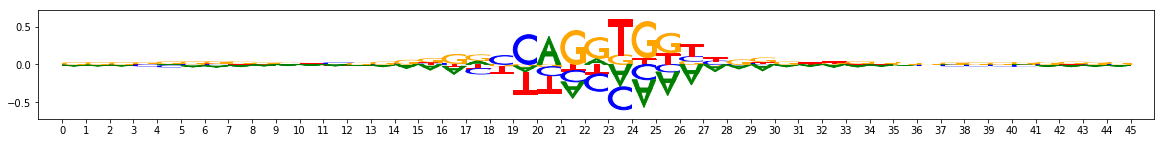

Task 0 actual importance scores:


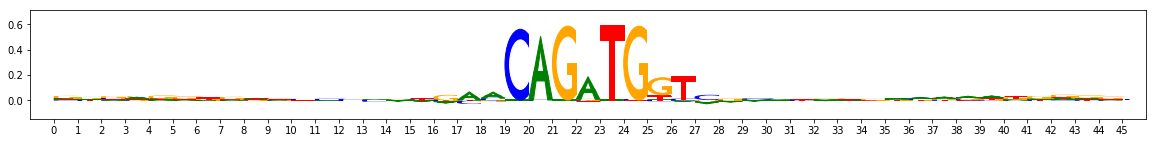

Task 1 hypothetical scores:


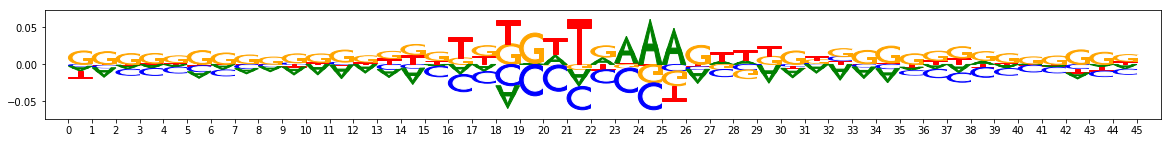

Task 1 actual importance scores:


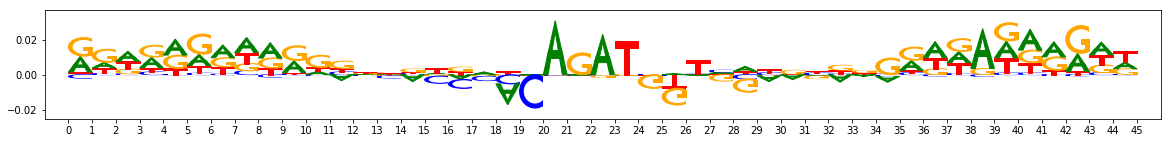

Task 2 hypothetical scores:


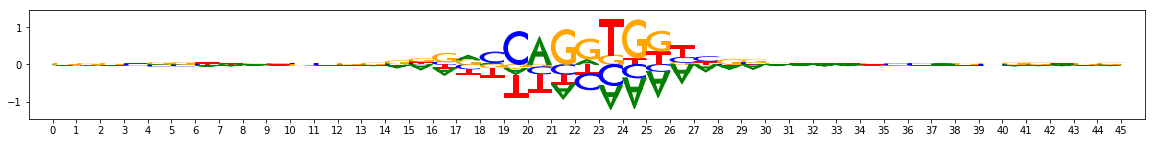

Task 2 actual importance scores:


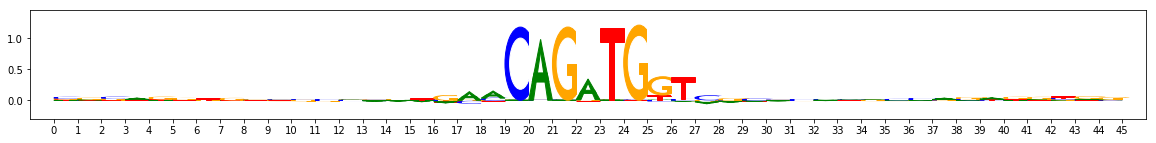

onehot, fwd and rev:


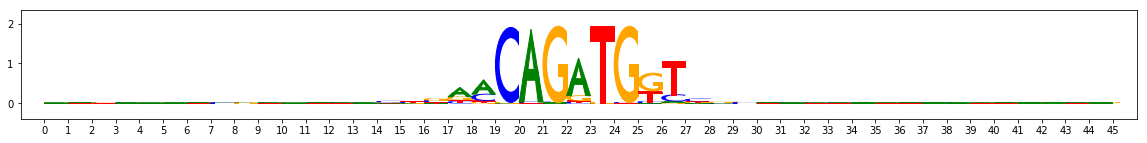

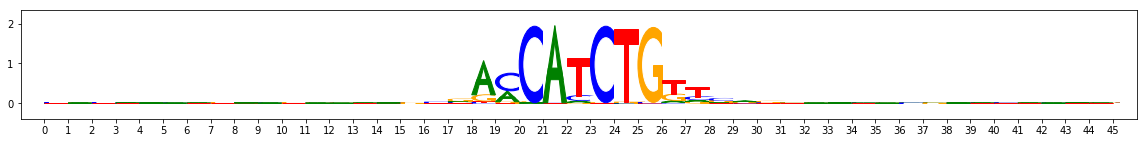

metacluster1
activity pattern: [1 1 0]
pattern_0
total seqlets: 379
Task 0 hypothetical scores:


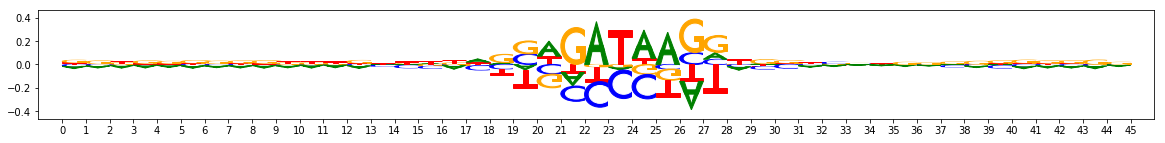

Task 0 actual importance scores:


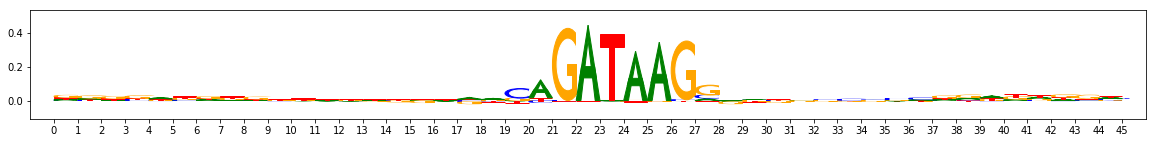

Task 1 hypothetical scores:


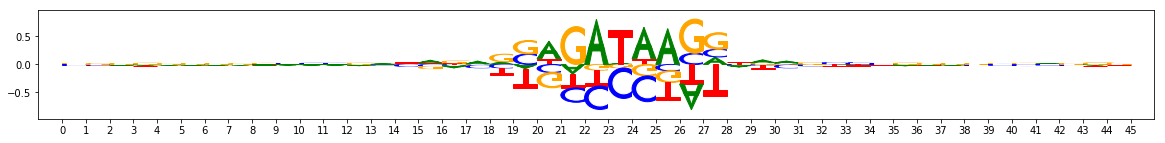

Task 1 actual importance scores:


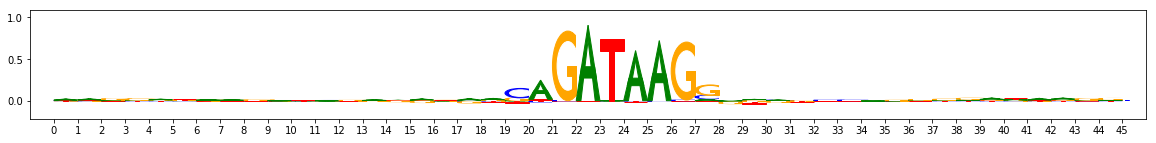

Task 2 hypothetical scores:


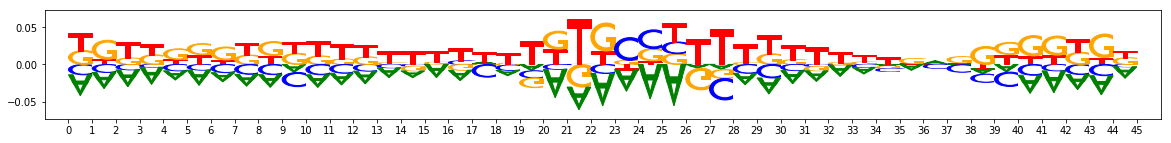

Task 2 actual importance scores:


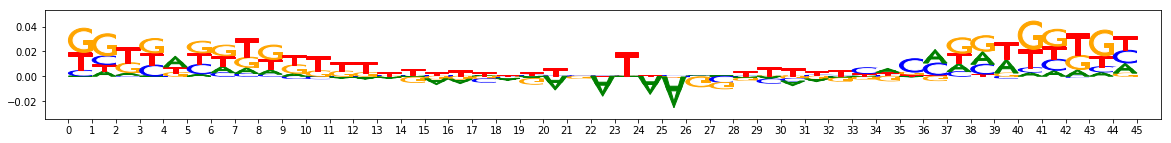

onehot, fwd and rev:


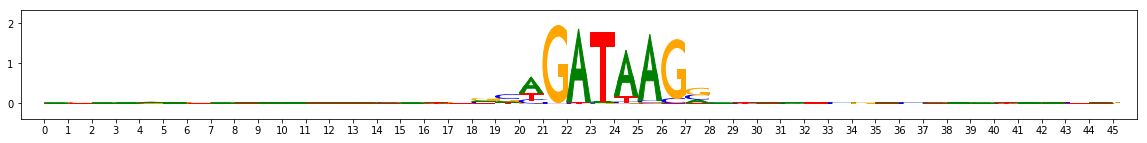

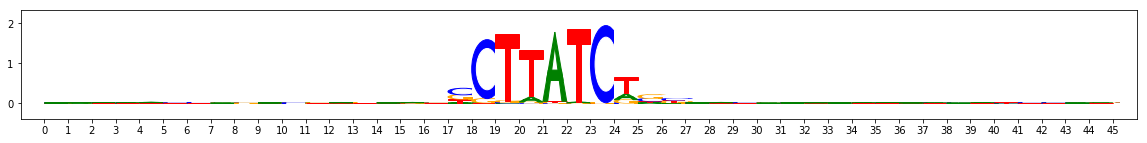

metacluster2
activity pattern: [0 1 0]
pattern_0
total seqlets: 116
Task 0 hypothetical scores:


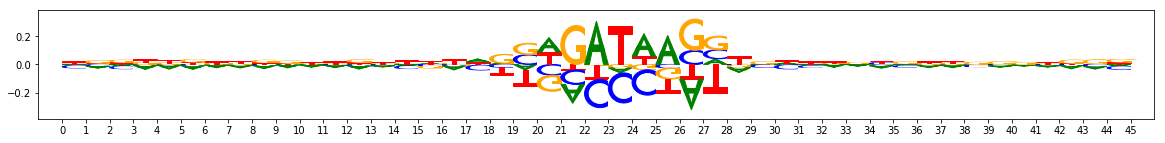

Task 0 actual importance scores:


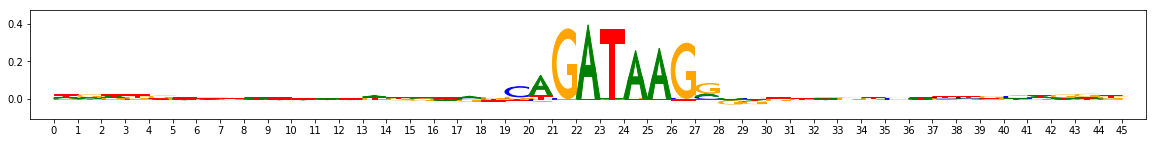

Task 1 hypothetical scores:


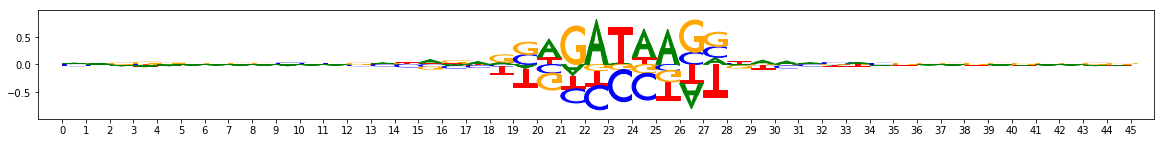

Task 1 actual importance scores:


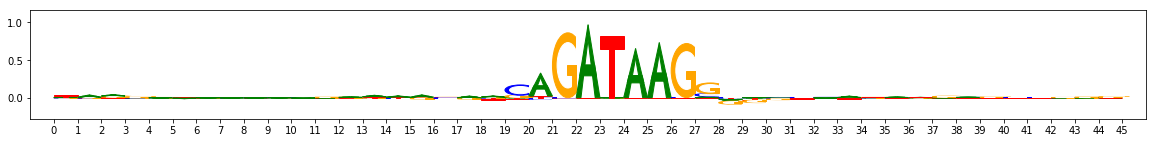

Task 2 hypothetical scores:


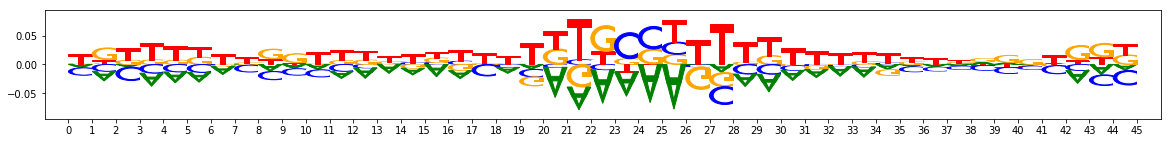

Task 2 actual importance scores:


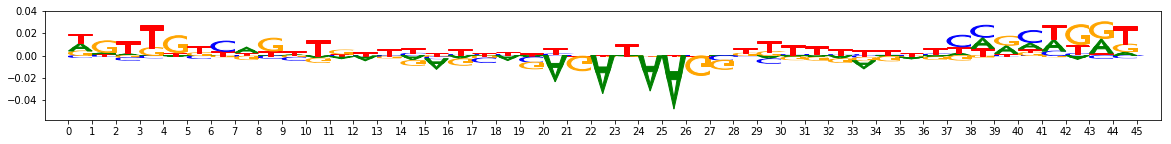

onehot, fwd and rev:


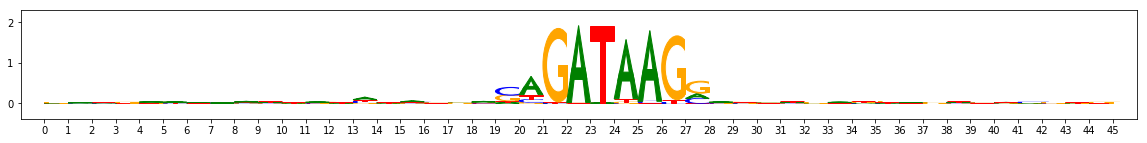

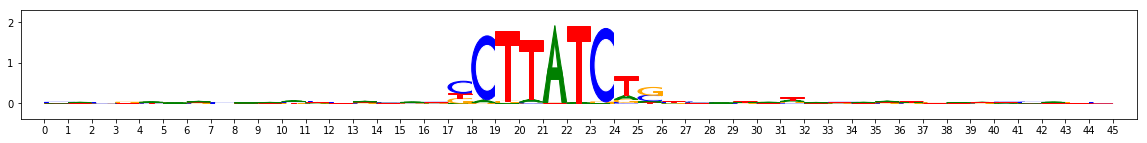

metacluster3
activity pattern: [0 0 1]
pattern_0
total seqlets: 143
Task 0 hypothetical scores:


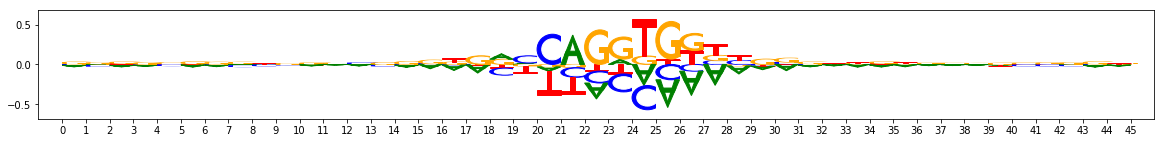

Task 0 actual importance scores:


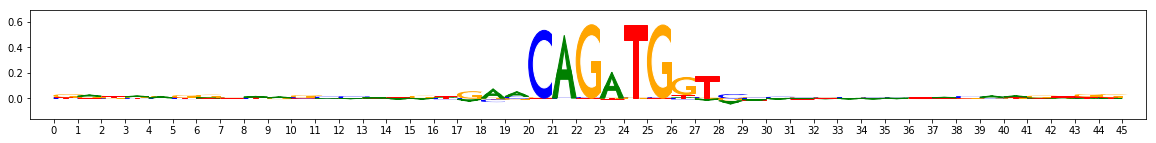

Task 1 hypothetical scores:


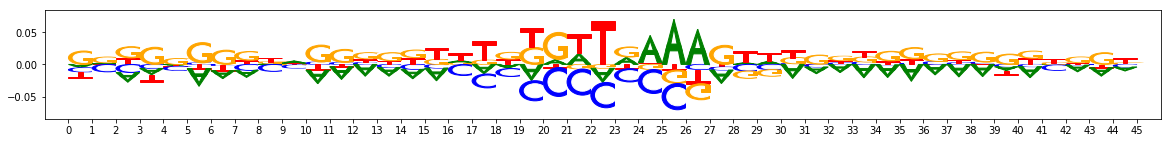

Task 1 actual importance scores:


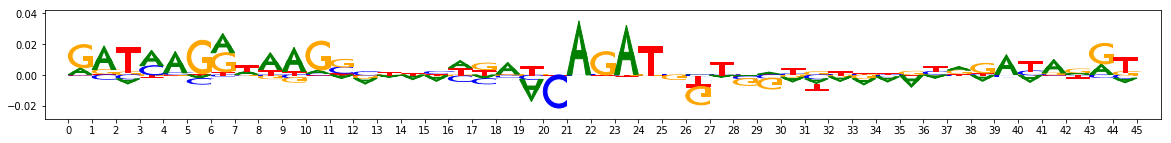

Task 2 hypothetical scores:


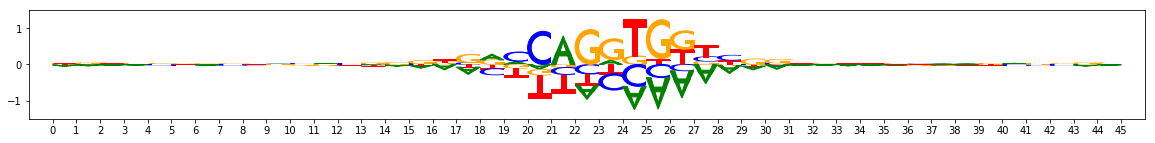

Task 2 actual importance scores:


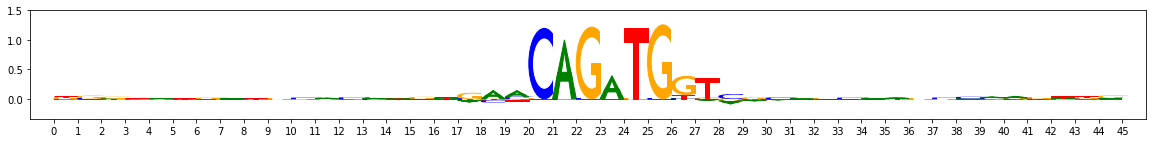

onehot, fwd and rev:


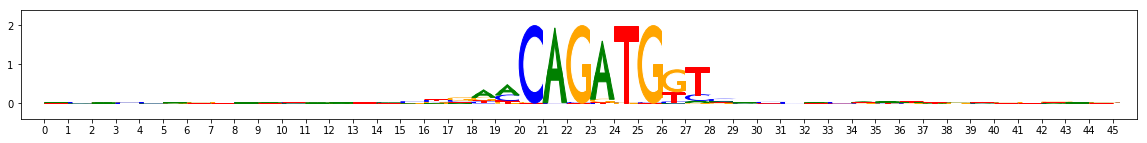

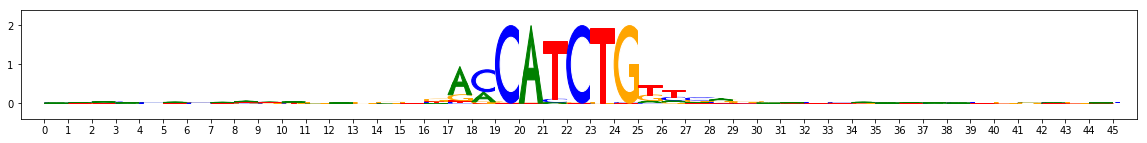

metacluster4
activity pattern: [1 1 1]
pattern_0
total seqlets: 90
Task 0 hypothetical scores:


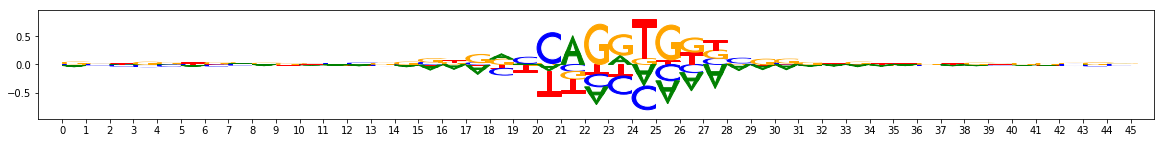

Task 0 actual importance scores:


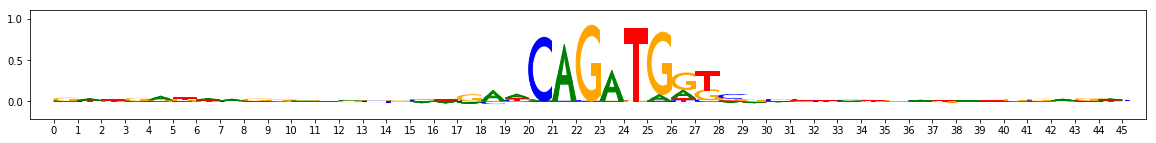

Task 1 hypothetical scores:


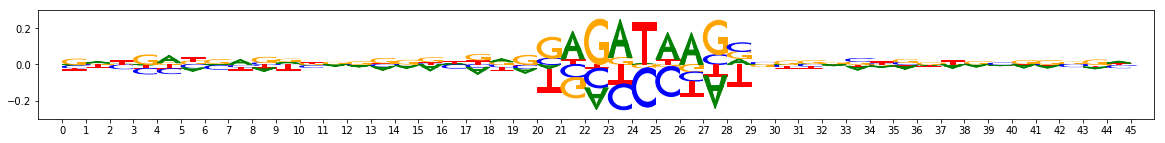

Task 1 actual importance scores:


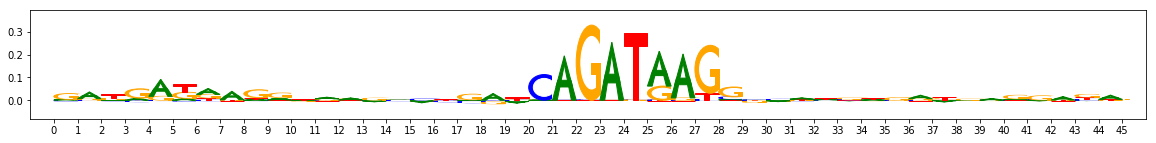

Task 2 hypothetical scores:


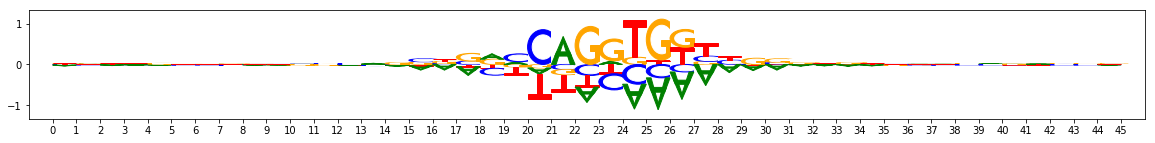

Task 2 actual importance scores:


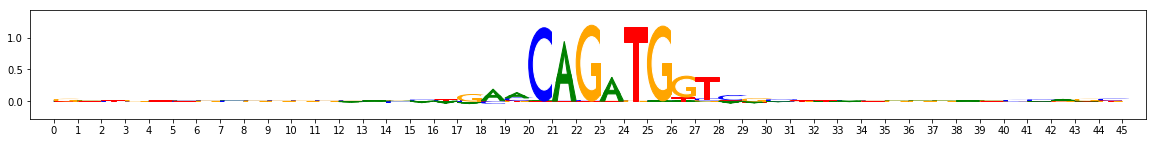

onehot, fwd and rev:


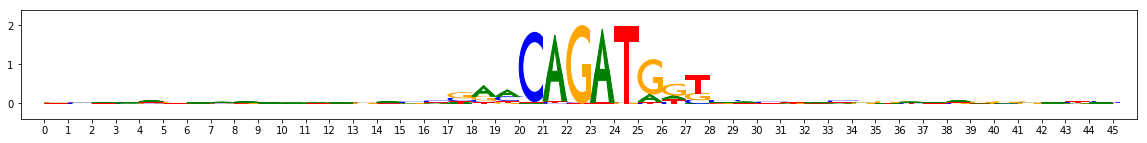

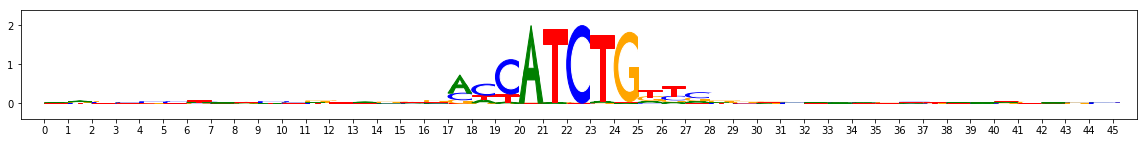

In [11]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5")

metacluster_names = list(hdf5_results["metaclustering_results"]["all_metacluster_names"][:])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = (list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:]))
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(pattern_name)
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()